## **3.1 Carga de datos**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

df_processed = pd.read_csv('/content/drive/MyDrive/NLP/df_processed.csv')

# Vamos a eliminar los posibles na que han podido aparecer en el preprocesado. Se deben a reviews que solo contenian stop words, y vimos que eran unas 50
df_processed.dropna(inplace=True)

In [ ]:
df_processed.head()

,reviewText,sentiment,processed_reviews
0,It's got a lot more kick than what you'll find...,1,got lot kick find local grocery store give sol...
1,"Cookies seemed a little old, did not come with...",0,cooky seemed little old come bag heart domino ...
2,These caramels are grainy and tasteless. They ...,0,caramel grainy tasteless chewy like normal car...
3,"very good , strong",1,good strong
4,"Not as good as home made from scratch, but not...",1,good home made scratch bad lot easier sure bac...


In [ ]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40714 entries, 0 to 40764
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   reviewText         40714 non-null  object
 1   sentiment          40714 non-null  int64 
 2   processed_reviews  40714 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


## **3.2 División y Vectorización**

Ahora vamos a preparar los datos para poder entrenar un modelo usando Bag of Words (BoW). Trataremos después de hacer una búsqueda de hiperparámetros que pueda optimizar el resultado.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_processed['processed_reviews'], df_processed['sentiment'], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=0)

# Verificar los tamaños de los conjuntos
print("Tamaño de train:", X_train.shape)
print("Tamaño de val:", X_val.shape)
print("Tamaño de test:", X_test.shape)

Tamaño de train: (27685,)
Tamaño de val: (4886,)
Tamaño de test: (8143,)


In [4]:
# Vectorizamos

vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_val_bow = vectorizer.transform(X_val)
X_test_bow = vectorizer.transform(X_test)

## **3.3 Entrenamiendo de modelos Machine Learning**

Ahora vamos a entrenar algunos modelos. Probaremos con algunas opciones de clasificadores de Machine Learning, como Naive Bayes y algunos árboles de decisión. Para cada modelo buscaremos los mejores hiperparámetros.

Después también entrenaremos el modelo con redes neuronales

### **3.3.1 Clasificador Naive Bayes**

In [ ]:
# Clasificador Naive Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.1, 1.0, 10.0]
}

nb_classifier = MultinomialNB()

grid_search = GridSearchCV(estimator=nb_classifier, param_grid = param_grid, cv=5)
grid_search.fit(X_train_bow, y_train)

print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'alpha': 1.0}


In [ ]:
from sklearn.metrics import accuracy_score

y_val_pred_nb = grid_search.predict(X_val_bow)

accuracy = accuracy_score(y_val, y_val_pred_nb)

print("Validation accuracy: ", accuracy)

Validation accuracy:  0.7961522717969709


### **3.3.2 Clasificador Random Forest**

In [ ]:
# Clasificador con Random Forest

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

maxDepth = range(10, 20)
nEstimators = [100, 200, 500]
param_grid = {'max_depth': maxDepth, 'n_estimators': nEstimators}

grid = GridSearchCV(RandomForestClassifier(random_state=0, max_features='sqrt'), scoring='accuracy', param_grid=param_grid, cv=5)
grid.fit(X_train_bow, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.629
best parameters: {'max_depth': 19, 'n_estimators': 100}


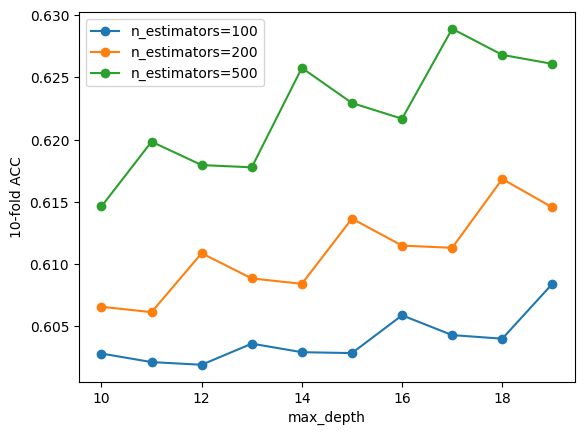

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

scores = np.array(grid.cv_results_['mean_test_score']).reshape(len(nEstimators), -1)

# Plot the data
for i, n_estimators in enumerate(nEstimators):
    plt.plot(maxDepth, scores[i], '-o', label=f'n_estimators={n_estimators}')

plt.xlabel('max_depth')
plt.ylabel('10-fold ACC')
plt.legend()
plt.show()

### **3.3.3 Clasificador Boosted Trees XGBoost**

In [ ]:
# Clasificador con Boosted Trees XGBoost

from xgboost import XGBClassifier

maxDepth = [5, 7, 10]
nEstimators = [100, 200, 300, 500, 1000]
learningRate = [0.1, 0.05, 0.01]
param_grid = {'max_depth': maxDepth, 'learning_rate':learningRate, 'n_estimators': nEstimators}

grid = GridSearchCV(XGBClassifier(random_state=0), param_grid = param_grid)
grid.fit(X_train_bow, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.813
best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}


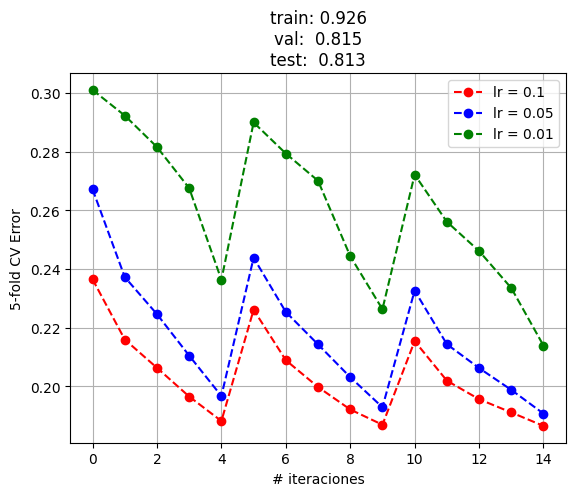

In [ ]:
# Aplicamos los parámetros óptimos

lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
maxDepthOptimo = grid.best_params_['max_depth']


xgb = XGBClassifier(random_state = 0, max_depth = maxDepthOptimo, learning_rate = lrOptimo, n_estimators = neOptimo) #,
                   #reg_alpha = 0.6, reg_lambda = 0.6)
xgb.fit(X_train_bow, y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate), -1)
colors = ['r','b','g','k','m']

for i, lr in enumerate(learningRate):
  x = np.arange(len(error[i, :]))
  plt.plot(x, error[i,:], colors[i] + '--o', label = 'lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\nval:  %0.3f\ntest:  %0.3f'%(xgb.score(X_train_bow,y_train), xgb.score(X_val_bow, y_val), xgb.score(X_test_bow,y_test)))
plt.grid()
plt.show()

### **3.3.4 Clasificador Gradient Boosting Machine**

In [ ]:
# Ahora vamos a probar también con un Gradient Boosting Machine, que se enfoca en mejorar el rendimiento secuencialmente mediante la combinación de varios árboles débiles

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

maxDepth = [5, 7, 10]
nEstimators = [100, 200, 300, 500, 1000]
learningRate = [0.1, 0.05, 0.01]
param_grid = {'max_depth': maxDepth, 'learning_rate':learningRate, 'n_estimators': nEstimators}

grid = GridSearchCV(GradientBoostingClassifier(random_state=0), param_grid = param_grid)
grid.fit(X_train_bow, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

In [ ]:
# Aplicamos los parámetros óptimos

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

# best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

# Tras ver que el entrenamiento puede tardar más del tiempo que Colab permite estar conectado y que no podemos terminar el entrenamiento,
# vamos a prescindir de GridSearch para entrenar Gradient Boosting Machine y utilizaremos los hiperparámetros que mejor se ajustaban con xgboost

# lrOptimo = grid.best_params_['learning_rate']
# neOptimo = grid.best_params_['n_estimators']
# maxDepthOptimo = grid.best_params_['max_depth']


gbc = GradientBoostingClassifier(random_state = 0, max_depth = 10, learning_rate = 0.1, n_estimators = 1000)
gbc.fit(X_train_bow, y_train)



GradientBoostingClassifier(max_depth=10, n_estimators=1000, random_state=0)

In [ ]:
#error = 1-gbc.cv_results_['mean_test_score'].reshape(len(learningRate), -1)
colors = ['r','b','g','k','m']

#for i, lr in enumerate(learningRate):
#  x = np.arange(len(error[i, :]))
#  plt.plot(x, error[i,:], colors[i] + '--o', label = 'lr = %g'%lr)

print("[{}] Accuracy: train = {}, val = {}, test = {}".format(
            gbc.__class__.__name__,
            gbc.score(X_train_bow, y_train),
            gbc.score(X_val_bow, y_val),
            gbc.score(X_test_bow, y_test)))

[GradientBoostingClassifier] Accuracy: train = 0.9552826440310638, val = 0.8108882521489972, test = 0.8105120962790127


De los modelos ML, nos quedamos por ahora con XGBoost, que es el que mejores resultados nos ha dado y además tiene unos buenos tiempos de entrenamiento. Podríamos aplicar regularización en futuras iteraciones para reducir algo el posible overfitting que pueda tener.

Vamos a probar ahora con algunos modelos de Deep Learning. Sería interesante poder comparar las diferencias entre modelos y su complejidad.
Para ello, primero crearemos nuestra propia RNN (LSTM) y después exploraremos la utilización de un modelo BERT preentrenado, y compararemos los resultados.



## **3.4 Entrenamiento Modelos Deep Learning**

### **3.4.1 Padding para rellenar vectores**

In [ ]:
# En primer lugar vamos a revisar la longitud media de las reviews, ya que necesitamos rellenar con 0 aquellas que sean cortas

max_length = 0
total_length = 0

for example in X_train_bow:
    length = example.getnnz()
    total_length += length
    if length > max_length:
        max_length = length

mean_length = total_length / X_train_bow.shape[0]

print("Max Length:", max_length)
print("Mean Length:", mean_length)

Max Length: 433
Mean Length: 17.527000180603213


In [ ]:
max_length / mean_length

24.704741001782644

In [ ]:
# Vamos a utilizar padding para que todos los vectores tengan longitud fija aprox el doble de sum(mean)/len(mean)
from tensorflow.keras.utils import pad_sequences

max_words = 40

# Convertimos las matrices dispersas a arrays densos
X_train_dense = X_train_bow.toarray()
X_val_dense = X_val_bow.toarray()
X_test_dense = X_test_bow.toarray()

X_train_dl = pad_sequences(X_train_dense, maxlen=max_words)
X_val_dl = pad_sequences(X_val_dense, maxlen=max_words)
X_test_dl = pad_sequences(X_test_dense, maxlen=max_words)

In [ ]:
# Necesitamos el vocabulary size. En lugar de poner uno fijo, pondremos el tamaño real de nuestro vocabulario:

from sklearn.feature_extraction.text import CountVectorizer

# Crear el CountVectorizer
vectorizer = CountVectorizer()

# Ajustar el vectorizer y transformar los textos en la matriz término-documento
matriz_term_doc = vectorizer.fit_transform(df_processed['processed_reviews'])

# Obtener el tamaño del vocabulario (número de términos únicos)
vocabulary_size = len(vectorizer.get_feature_names_out())

print("Vocabulary size:", vocabulary_size)

Vocabulary size: 23795


### **3.4.2 Red LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size = 100
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words)) # Activamos return_sequences, para pasar la secuencia completa a la siguiente capa LSTM
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.25)) # Dropout para reducir el overfit
model.add(LSTM(64))
model.add(Dense(64, activation='relu')) # Agregamos una capa densa con activación relu para tratar de capturar relaciones más complejas entre las características aprendidas en las capas LSTM
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 100)           2379500   
                                                                 
 lstm_3 (LSTM)               (None, 40, 128)           117248    
                                                                 
 dropout_1 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,550,381
Trainable params: 2,550,381
No

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 64
num_epochs = 20

model.fit(X_train_dl, y_train,
          validation_data=(X_val_dl, y_val),
          batch_size=batch_size, epochs=num_epochs)

Epoch 1/20
433/433 [==============================] - 74s 163ms/step - loss: 0.6735 - accuracy: 0.6014 - val_loss: 0.6719 - val_accuracy: 0.6038
Epoch 2/20
433/433 [==============================] - 75s 172ms/step - loss: 0.6729 - accuracy: 0.6014 - val_loss: 0.6727 - val_accuracy: 0.6038
Epoch 3/20
433/433 [==============================] - 67s 153ms/step - loss: 0.6728 - accuracy: 0.6014 - val_loss: 0.6723 - val_accuracy: 0.6038
Epoch 4/20
433/433 [==============================] - 63s 145ms/step - loss: 0.6728 - accuracy: 0.6014 - val_loss: 0.6719 - val_accuracy: 0.6038
Epoch 5/20
433/433 [==============================] - 63s 146ms/step - loss: 0.6726 - accuracy: 0.6014 - val_loss: 0.6715 - val_accuracy: 0.6038
Epoch 6/20
433/433 [==============================] - 64s 148ms/step - loss: 0.6726 - accuracy: 0.6014 - val_loss: 0.6715 - val_accuracy: 0.6038
Epoch 7/20
433/433 [==============================] - 64s 147ms/step - loss: 0.6726 - accuracy: 0.6014 - val_loss: 0.6715 - val_ac

In [ ]:
scores = model.evaluate(X_test_dl, y_test, verbose=0)  # returns loss and other metrics specified in model.compile()
print("Test accuracy:", scores[1])  # scores[1] should correspond to accuracy if you passed in metrics=['accuracy']

Test accuracy: 0.5930246710777283


El modelo LSTM no logra alcanzar unos buenos resultados, si comparamos con los modelos ML.
Sería interesante modificar algunas capas de la red, añadir algunas, probar con diferentes regularizaciones y probar modificando algunos parámetros. Por ahora seguiremos avanzando y lo veremos en siguientes iteraciones, ya que queremos ver los resultados base y comparar con otros modelos.

 Probaremos a utilizar ahora un modelo preentrenado BERT.

### **3.4.3 Modelo BERT Preentrenado**

A continuación se muestra el desarrollo del **modelo de transformers BERT**, el cuál no se ha logrado hacer funcionar debido a la **limitación de memoria de Colab** (tampoco hubiera sido posible con la capacidad de mi equipo actual en un Jupyter Notebook).
Se probó a dividir en batches con la idea de lotear y que la gestión de memoria permitiera procesar los embeddings, pero aún con batches muy pequeños no fue posible y tras varias horas de ejecución el notebook se caía.

Se deja no obstante el código para seguir intentando resolver el problema en posteriores iteraciones.

In [ ]:
! pip install transformers tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.1 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Descargamos el tokenizador BERT y el modelo preentrenado

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_vocab_size=1000)
model = TFBertModel.from_pretrained('bert-base-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
import numpy as np

# Para utilizar el modelo preentrenado, debemos tokenizar de nuevo, usando el tokenizador de Bert

# Obtener los textos y dividirlos en lotes más pequeños
texts = df_processed['reviewText'].tolist()
batch_size = 8
num_batches = int(np.ceil(len(texts) / batch_size))


In [ ]:
# Pasamos los datos tokenizados al modelo para obtener los embeddings

# Procesar los lotes y obtener los embeddings
embeddings_list = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch_texts = texts[start_idx:end_idx]

    encoded_data = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='tf')
    model_outputs = model(**encoded_data)
    embeddings = model_outputs.last_hidden_state
    embeddings_list.append(embeddings)

# Concatenar los embeddings de los lotes en un único tensor
all_embeddings = tf.concat(embeddings_list, axis=0)

Ha habido algunos problemas con la gestión de memoria. Bert excedía lo permitido por Colab y he tenido que dividir el conjunto de datos en lotes y procesarlo por lotes (batching).
También se hicieron pruebas con la librería **TFLiteConverter** para obtener un modelo 'lite' pero tampoco fue suficiente. También limitamos el tamaño del vocabulario de Bert a riesgo de obtener unos resultados pobres, pero tampoco fue suficiente para hacerlo funcionar.

## **3.5 Conclusiones**

El modelo con el que nos quedaremos finalmente será con el **clasificador Boosted Trees XGBoost**, que nos ha dado una accuracy de 0.813, por encima de cualquiera de los otros modelos.

En mi opinión, esto demuestra la dificultad de entrenar una red neuronal para obtener buenos resultados ya que, más allá de la preparación mejor o peor de los datos, es necesario diseñar una arquitectura adecuada, o tener un modelo preentrenado adecuado, además de una gran capacidad de procesamiento.

A continuación, guardaremos el modelo para poder utilizarlo en el siguiente notebook (Reporte de métricas y conclusiones)

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Aplicaremos los best parameters directamente.
# best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

lrOptimo = 0.1
neOptimo = 1000
maxDepthOptimo = 10


xgb = XGBClassifier(random_state = 0, max_depth = maxDepthOptimo, learning_rate = lrOptimo, n_estimators = neOptimo,
                   reg_alpha = 0.6, reg_lambda = 0.6) # Le aplicamos regularización y logramos mejorar un poco el resultado, de 0.815 a 0,8166
xgb.fit(X_train_bow, y_train)

from sklearn.metrics import accuracy_score

y_pred = xgb.predict(X_val_bow)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8166189111747851


In [9]:
# Guardamos el modelo

import joblib

model_filename = '/content/drive/MyDrive/NLP/sentiment_analysis_model.pkl'
joblib.dump(xgb, model_filename)

['/content/drive/MyDrive/NLP/sentiment_analysis_model.pkl']

In [10]:
# Guardamos los datos de test para poder calcular las métricas en el siguiente notebook
import pandas as pd

test_data = pd.DataFrame ({'processed_reviews': X_test, 'sentiment': y_test})

test_path = '/content/drive/MyDrive/NLP/test_data.csv'

test_data.to_csv(test_path, index=False)


In [11]:
# Guardamos también el Vectorizer para poder usarlo en el otro notebook

joblib.dump(vectorizer, '/content/drive/MyDrive/NLP/vectorizer.pkl')

['/content/drive/MyDrive/NLP/vectorizer.pkl']